# Age prediction with major features from Cam-CAN

In [1]:
import numpy as np
from camcan.datasets import load_camcan_behavioural

path_data = '/home/lemaitre/Documents/data/camcan/cc700-scored/total_score.csv'
path_participants_info = '/home/lemaitre/Documents/data/camcan/cc700-scored/participant_data.csv'
path_selected_features = "/home/lemaitre/Documents/data/camcan/cc700-scored/features"

# load the interesting features
features_name = ['Observations']
with open(path_selected_features, mode="rt", encoding="utf-8") as f:
    for row in f:
        features_name.append(row.strip())

dataset = load_camcan_behavioural(path_data, path_participants_info, column_selected=features_name)

X = dataset.data
y = dataset.scores.age

In [2]:
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(Imputer(), Ridge())
y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True))

print('R2 score: {}'.format(r2_score(y, y_pred)))
print('Median absolute deviation score: {}'.format(median_absolute_error(y, y_pred)))

R2 score: 0.6171423068091734
Median absolute deviation score: 6.945381014224779


/home/lemaitre/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


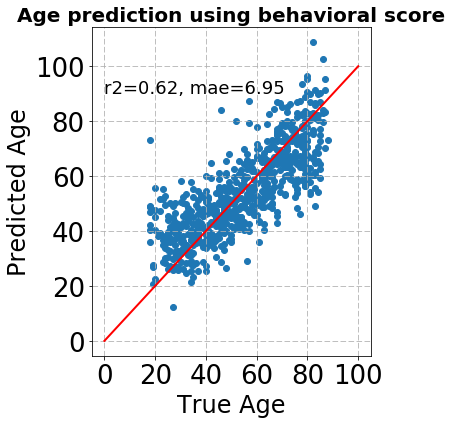

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

f = plt.figure(figsize=(6, 6))
ax = f.gca()
ax.scatter(y, y_pred)
ax.plot([0, 100], [0, 100], 'r', linewidth=2)
ax.grid(linestyle='--')
xlabels = ['%u' % x for x in ax.get_xticks()]
ax.set_xticklabels(xlabels, fontsize=26)
labels = ['%u' % x for x in ax.get_yticks()]
ax.set_yticklabels(labels, fontsize=26)
ax.set_ylabel('Predicted Age', fontsize=24)
ax.set_xlabel('True Age', fontsize=24)
ax.text(0, 90, 'r2=%.2f, mae=%.2f' % (r2_score(y, y_pred), median_absolute_error(y, y_pred)),
        fontsize=18)
ax.set_title('Age prediction using behavioral score',
             fontsize=20, fontweight='bold')
f.tight_layout()
f.show()

# Process all data

In [4]:
import numpy as np
import seaborn as sns
import pandas as pd
from camcan.datasets import load_camcan_behavioural
from camcan.datasets import load_camcan_behavioural_feature

path_data = '/home/lemaitre/Documents/data/camcan/cc700-scored/total_score.csv'
path_participants_info = '/home/lemaitre/Documents/data/camcan/cc700-scored/participant_data.csv'
path_selected_features = "/home/lemaitre/Documents/data/camcan/cc700-scored/behavioural_features.json"

experiment_feature_to_exclude = load_camcan_behavioural_feature("HomeInterview", path_selected_features)
print('The number of features for this experiment is {}'.format(len(experiment_feature_to_exclude)))

dataset = load_camcan_behavioural(path_data, path_participants_info)

X = dataset.data
y = dataset.scores.age

# remove home interview
X = X.drop(list(experiment_feature_to_exclude), axis=1)

# retain only numeric data
X = X.select_dtypes(include=[np.number])
column_names = X.columns
X = Imputer().fit_transform(X)
# remove constant feature
non_contant_feature = np.ones((X.shape[1], ), dtype=bool)
constant_feature = [16, 17, 18, 43, 44, 69, 70, 95, 96, 121, 122, 367, 381, 382, 383, 406, 422, 477,
478, 479, 480, 481, 499, 500, 502, 503, 508, 534, 536, 537, 556, 557, 572, 573, 574, 575,
576, 578, 579, 580, 581, 582, 583, 585, 586, 587, 588, 589, 590, 591, 595, 596, 597, 599,
600, 601, 602, 603, 604]
non_contant_feature[constant_feature] = False
X = X[:, non_contant_feature]
column_names = column_names[non_contant_feature]

The number of features for this experiment is 26


In [9]:
# from joblib import Memory
from sklearn.externals.joblib import Memory
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline

memory = Memory(cachedir='/tmp',verbose=0)
pipeline = Pipeline(memory=memory,
                    steps=[('selectkbest', SelectKBest(f_regression, k=10)),
                           ('ridge', RandomForestRegressor(n_estimators=50))])

r2_score_records = []
mad_score_records = []
for k in np.arange(10, X.shape[1], 5, dtype=int):
    pipeline.set_params(selectkbest__k=k)
    y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True), n_jobs=-1)
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y)
    # pipeline.fit(X_train, y_train)
    # print(column_names[pipeline.named_steps['selectkbest'].get_support()])#
    # y_pred = pipeline.predict(X_test)
    # print(r2_score(y_test, y_pred))
    # print(median_absolute_error(y_test, y_pred))
    
    r2_score_records.append(r2_score(y, y_pred))
    mad_score_records.append(median_absolute_error(y, y_pred))

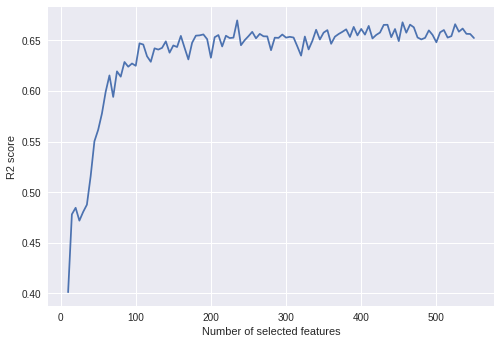

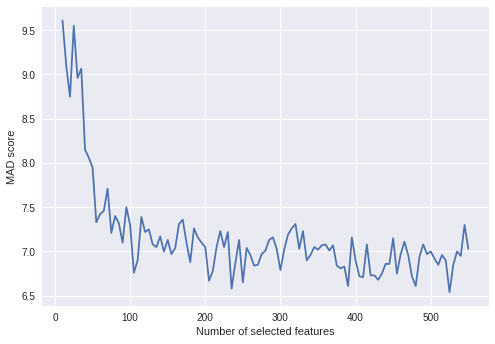

In [10]:
plt.figure()
k = np.arange(10, X.shape[1], 5, dtype=int)
plt.plot(k, r2_score_records, label='R2 score')
plt.xlabel('Number of selected features')
plt.ylabel('R2 score')

plt.figure()
plt.plot(k, mad_score_records, label='MAD score')
plt.xlabel('Number of selected features')
plt.ylabel('MAD score')

In [ ]:
# from joblib import Memory
from sklearn.externals.joblib import Memory
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression, SelectFromModel
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, train_test_split
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline

memory = Memory(cachedir='/tmp',verbose=0)
pipeline = Pipeline(memory=memory,
                    steps=[('selectkbest', SelectKBest(f_regression, k=10)),
                           ('ridge', RandomForestRegressor(n_estimators=50))])

r2_score_records = []
mad_score_records = []
for k in np.arange(10, X.shape[1], 5, dtype=int):
    pipeline.set_params(selectkbest__k=k)
    y_pred = cross_val_predict(pipeline, X, y, cv=KFold(n_splits=10, shuffle=True), n_jobs=-1)
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y)
    # pipeline.fit(X_train, y_train)
    # print(column_names[pipeline.named_steps['selectkbest'].get_support()])#
    # y_pred = pipeline.predict(X_test)
    # print(r2_score(y_test, y_pred))
    # print(median_absolute_error(y_test, y_pred))
    
    r2_score_records.append(r2_score(y, y_pred))
    mad_score_records.append(median_absolute_error(y, y_pred))

# Per experiment analysis

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from camcan.datasets import load_camcan_behavioural_feature
from camcan.datasets import load_camcan_behavioural

path_data = '/home/lemaitre/Documents/data/camcan/cc700-scored/total_score.csv'
path_participants_info = '/home/lemaitre/Documents/data/camcan/cc700-scored/participant_data.csv'
path_selected_features = "/home/lemaitre/Documents/data/camcan/cc700-scored/behavioural_features.json"

experiment_feature = load_camcan_behavioural_feature("EkmanEmHex", path_selected_features)
print('The number of features for this experiment is {}'.format(len(experiment_feature)))

dataset = load_camcan_behavioural(path_data, path_participants_info,
                                  column_selected=tuple(['Observations'] + list(experiment_feature)))

X = dataset.data
X = Imputer().fit_transform(X)

y = np.array(dataset.scores.age)
y = (np.floor(y / 10) * 10).astype(int)
X = np.hstack((X, np.atleast_2d(y).T))
X = pd.DataFrame(data=X, columns=list(experiment_feature) + ['age'])

In [ ]:
sns.pairplot(X.sample(50), hue='age')
plt.show()